Import the libraries

In [77]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals



%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
# These steps are typically always called.  The "matplotlib inline" is to display figures in this notebook itself 


import pandas as pd 
# pandas is a library for handling datasets; you will see some useful built-in functions in action

import os # to move around your operating system

import scipy as sp  # scientific computation library

from mpl_toolkits.mplot3d import axes3d # in case we need to plot in 3D z=f(x,y)
import seaborn as sns  # another package for pretty graphs

# Scikit-learn (sklearn) is a powerful and fairly comprehensive library of ML algorithms

from sklearn import datasets
from sklearn.neighbors.kde import KernelDensity

Defining the dataset

(50,)


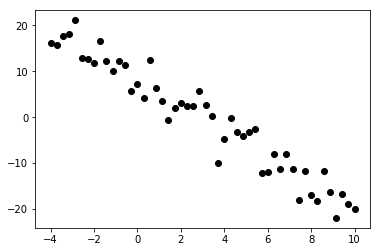

In [78]:
def f1(x, m, c): # y = m*x + c (ground truth function)
    return m*x + c 
xmin, xmax, npts = [-4, 10, 50]
X = np.linspace(xmin, xmax, npts) # defining domain of the function as a vector of 50 real numbers between 0 and 5
print(np.shape(X))
# Create data from ground truth function that is corrupted by additive Gaussian noise of mean 0 and std. dev. 4
y0 = f1(X, -3., 9.) + np.random.normal(0,scale=4, size=np.shape(X))  
plt.scatter(X, y0, marker='o', c='k')

Next step: The design matrix is formed by (1) assembling each input vector as a row and (2) adding a column of ones. In this case the input vector is a scalar. We will end up with a design matrix of size (2-times-N) where N is the number of data points. This sets up the linear equation  Aw=y .

In [79]:
def designmat1(Xmat):
    X = np.atleast_2d(Xmat).T
    col1 = np.ones(np.shape(X)[0]).reshape(np.shape(X)[0],1)
    X = np.concatenate((col1, X), axis=1) 
    return X

designmat1(X).shape

(50, 2)

### Find optimal weights by gradient descent

Find the weight vector  w  by minimising the length of the residual vector  r(w):=y−Aw  by gradient descent. From the lecture slides/tutorial exercises you should be able to verify that the function "gradsqloss" corresponds to the gradient of the average of squared residuals loss function.

In [80]:
def gradsqloss(Amat, y, wt):
    n, p = Amat.shape
    return (-2/n)*Amat.T.dot((y - Amat.dot(wt)))

def gradientDescent(Amat, y, winit, rate, num_iters):
    whistory = []
    meanrsshistory = []
    w = winit
    
    for i in range(num_iters):
        meanrss = np.square(y - Amat.dot(w)).mean()
        whistory.append(w)
        meanrsshistory.append(meanrss)
        grad = gradsqloss(Amat, y, w)
        w = w - rate * grad
    return w, np.asarray(whistory), np.asarray(meanrsshistory)

Text(0, 0.5, 'mean of sum of squares of residual')

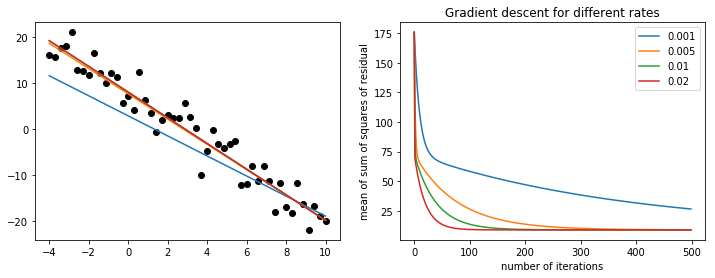

In [81]:
Xmat = designmat1(X)

n, p = Xmat.shape

# generate p random wts

w0 = np.random.randn(p)

num_iters = 500

rates = [.001,.005,.01,.02]

# test set data + plot

xinput = np.linspace(-4,10,100)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
ax[0].scatter(X,y0,marker='o',color='k')

for i, r in enumerate(rates):
    wfin, whist, meanlosstrace = gradientDescent(Xmat, y0,  w0, r, num_iters)
    ax[1].plot(meanlosstrace,label=r)
    ax[0].plot(xinput,wfin[0]+wfin[1]*xinput, label = r)


ax[1].legend() 
ax[1].set_title("Gradient descent for different rates")
ax[1].set_xlabel("number of iterations")
ax[1].set_ylabel("mean of sum of squares of residual")

### Use linear regression to fit non-linear models

Next you will see how linear regression can be used to fit non-linear models. For instance, a quadratic function

$$f(x; \mathbf{w}) = w_0 + w_1 x^2 + w_2 x^2$$


where  w=(w0,w1,w2)  is the weight vector to be learnt from data.


\begin{array}{rcl}f:X&\rightarrow &Y_0\\\mbox{where }\forall x\in X,\quad x&\mapsto & y_0(x)\in Y_0 \\y_0(x)&=&\displaystyle \left(\frac{x}{3}\right)^2\exp\left(-\left(\frac{x}{6}\right)^2\right)+\mbox{'noise'}.\\\end{array}

Here, the set  X  is a set of equally spaced points between  0  and  1 , and the noise terms are drawn from a normal distribution with mean 0 and standard deviation 1.



Generating the data

In [82]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


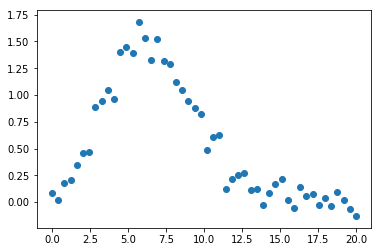

In [83]:
def f2(x):
    return (x/3)**2*np.exp(-(x/6)**2)

X = np.linspace(0, 20, 50)

y2=f2(X)+np.random.normal(0,0.1,50)

X = np.atleast_2d(X).T

plt.scatter(X, y2)

Splitting up the data

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size = 0.33, random_state = 40)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33, 1) (17, 1) (33,) (17,)


$$y_n = w_0 + w_1 x_n + w_2 x_n^2, n=1, \ldots, N.$$

his leads to the set of simulataneous linear equations  Aw=y :
$$
\overbrace{\left(
\begin{array}{ccc}
1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2
\end{array}\right)}^{\mathbf{A}}\left(
\begin{array}{c}
w_0\\w_1\\ w_2
\end{array}\right)=\overbrace{\left(\begin{array}{c}
y_1\\y_2\\\vdots\\y_N
\end{array}\right)}^{\mathbf{y}},$$

The matrix  A  is called the design matrix. We construct the design matrix next.

In [85]:
from sklearn.preprocessing import PolynomialFeatures

poly2feat = PolynomialFeatures(degree =2, include_bias = True)

A_test_sklearn = poly2feat.fit_transform(X_test) # scikit-learn's design matrix
A_train_sklearn = poly2feat.fit_transform(X_train)

A_train_sklearn.shape

(33, 3)

For degree: 1
[ 0.         -0.05707613] 1.14277851025
For degree: 2
[ 0.          0.10539152 -0.00807246] 0.591125636124
For degree: 3
[ 0.          0.67235121 -0.07663754  0.00224801] -0.454409169907
For degree: 4
[  0.00000000e+00   8.45429915e-01  -1.14740819e-01   5.19631376e-03
  -7.35961543e-05] -0.650579511392
For degree: 5
[  0.00000000e+00   1.14789195e-01   1.35200205e-01  -2.79212572e-02
   1.78741526e-03  -3.72574525e-05] -0.102160918657


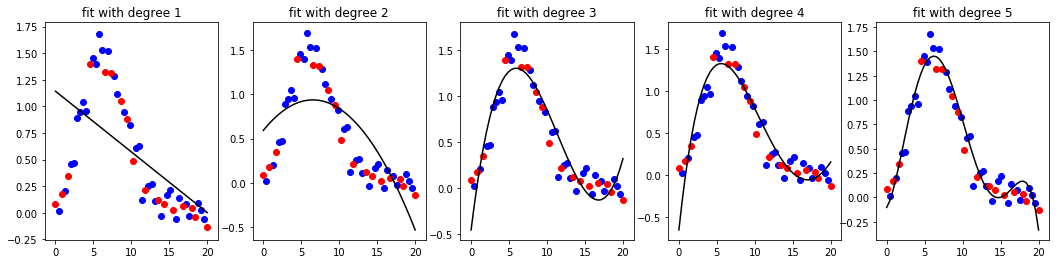

In [91]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

fig, ax = plt.subplots(figsize=(18,4),nrows=1, ncols=5,sharex='col')

for d in range(5):
    features = PolynomialFeatures(degree = d+1, include_bias = True)
    
    X_feature = features.fit_transform(X)
    X_feature_train =  features.fit_transform(X_train)
    X_feature_test =  features.fit_transform(X_test)
    
    regress = LinearRegression()
    
    regress.fit(X_feature_train, y_train)
    print ("For degree:", d+1)
    print (regress.coef_, regress.intercept_)
                
    y_predict=regress.predict(X_feature_test)
                              
    y_model = regress.predict(X_feature)
                              
    ax[d].scatter(X_train,y_train, c='b')
    ax[d].scatter(X_test, y_test, c='r')
    ax[d].plot(X, y_model, c='k')
    title = 'fit with degree '+str(d+1)
    ax[d].set_title(title)